# Compare 1 GY resampled weekly between QR and BLoomberg
**Method resampling (weekly) of Bloomberg:**
* Weekly data (on Friday) of Bloomberg: last available value of the week (Monday to Sunday) will be assigned to be value of the week (noted friday) ***despite weekend***. *This is the principal difference with  QR method*

**Method of QR:**
* **Friday resample**
    * Reindex business daily data to full daily (including weekend)
    * Forwarfill with limit = 6 (week fill)
    * Keep only *Friday*
* **Sunday resample**
    * Reindex business daily data to full daily (including weekend)
    * Forwarfill with limit = 6 (week fill)
    * Keep only *Sunday*

In this notebook, we exclude also end of month on friday because table is also initialized with frequency 'MONTHLY'

In this notebook, we identify 3 types of mismatch:
* Type A: BBG not NA, KC not NA, value different
* Type B: BBG not NA, KC NA
* Type C: BBG NA, KC not NA

#### Comparison resampled friday vs bloom
* Type A: 11 obs (differece >1%), mais negligeable, sur 2 security_ids
* Type B: 385 obs (93 obs après enlever EOM) BBG a des valeurs, KC est NA
* Type C: 60 (60 obs après enlever EOM) obs BBG est NA, KC a des valeurs

#### Comparison resampled Sunday vs bloom
* Type A: 157 obs (differece >1%), l'erreur est très grande (certaines >50%)
* Type B: 389 (146 après enlever EOM) obs BBG a des valeurs, KC est NA
* Type C: 30 (16 après enlever EOM) obs BBG est NA, KC a des valeurs

**Conclusion:**
* we can ignore sunday resample
* **we validate friday resample**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
import dbtools.src.dbtools_util as du
import warnings
from pandas.tseries.offsets import BDay
warnings.filterwarnings("ignore")
connector = SqlConnector()
con_mis = connector.connection()

In [3]:
## Load data
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']

df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_we_excel_test_100_stocks', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_1gy_daily_ts = df_daily_db[df_daily_db.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_2gy_daily_ts = df_daily_db[df_daily_db.attribute_id=='eps_2gy'].set_index(['DATE', 'security_id']).value.unstack()
df_bf_daily_ts = df_daily_db[df_daily_db.attribute_id=='eps_bf'].set_index(['DATE', 'security_id']).value.unstack()
df_excel_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_excel_test_100_stocks', con_mis)
df_excel_db.DATE = pd.to_datetime(df_excel_db.DATE)
df_excel_db.attribute_id = df_excel_db.attribute_id.replace(df_data_dict)

df_1gy_daily_ts = df_1gy_daily_ts.reindex(pd.date_range(df_1gy_daily_ts.index.min(),df_1gy_daily_ts.index.max()))

df_1gy_excel = df_excel_db[df_excel_db.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_2gy_excel = df_excel_db[df_excel_db.attribute_id=='eps_2gy'].set_index(['DATE', 'security_id']).value.unstack()
df_1gy_excel = df_1gy_excel[df_1gy_excel.index.weekday==4]
df_2gy_excel = df_2gy_excel[df_2gy_excel.index.weekday==4]

In [4]:
## security_id dont l'année fiscale ne change pas en 01 janvier
sec_anom = [258, 11963, 15210, 15726, 17821, 18590, 18678, 38718, 38763, 47044, 1037829, 2632714, 2752161, 2757656, 2764531, 2907194, 2925627]
sec_anom = pd.Index(sec_anom)

In [5]:
df_daily_leg = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_excel_test_100_stocks', con_mis)
df_daily_leg.DATE = pd.to_datetime(df_daily_leg.DATE)
df_daily_leg.attribute_id = df_daily_leg.attribute_id.replace(df_data_dict)
df_1gy_daily_leg = df_daily_leg[df_daily_leg.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_1gy_daily_leg = df_1gy_daily_leg.reindex(pd.date_range(df_1gy_daily_leg.index.min(),df_1gy_daily_leg.index.max()))

In [6]:
sec_common = df_1gy_daily_ts.columns
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')

In [7]:
df_daily_12gy = df_daily_db[df_daily_db.attribute_id.isin(['eps_1gy','eps_2gy'])]

In [8]:
df_daily_12gy.sort_values(['security_id','DATE']).head()

DATE attribute_id  security_id  value
0    2022-01-01      eps_1gy           25  4.803
85   2022-01-01      eps_2gy           25  5.058
443  2022-01-04      eps_1gy           25  4.803
459  2022-01-04      eps_2gy           25  5.058
2023 2022-01-18      eps_1gy           25  4.803

## Comparison 1GY

In [9]:
## Sampling (weekly example)
# reindex daily
# week fill (with limit = 6 jours)
# Resample weekly (friday)

filled_df = du.fill_week_with_nans(df_daily_12gy, date_column='DATE')
df_ffill = du.custom_forward_fill(filled_df, date_column='DATE', field='eps_1gy', group_by_columns=['attribute_id','security_id'])
resampled_df_fridays = du.resample_data(df_ffill, date_column='DATE', mode='weekly', calendar_type='friday')

resampled_df_sunday = du.resample_data(df_ffill, date_column='DATE', mode='weekly', calendar_type='sunday')
df_1gy_excel_sun = df_1gy_excel.copy()
df_1gy_excel_sun.index = df_1gy_excel_sun.index + pd.Timedelta('2D')
# reindex, use friday instead of sunday
#resampled_df_sunday.loc[:, 'DATE'] = resampled_df_sunday.DATE - pd.Timedelta('2D')

In [10]:
df_1gy_res_fri = resampled_df_fridays[resampled_df_fridays.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_1gy_res_fri = df_1gy_res_fri[df_1gy_res_fri.index>=df_1gy_excel.index.min()]
df_1gy_res_sun = resampled_df_sunday[resampled_df_sunday.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_1gy_res_sun = df_1gy_res_sun[df_1gy_res_sun.index>=df_1gy_excel_sun.index.min()]

In [11]:
### Fonction  detail_diff: security_id, date, 
# output: dict security_id, date, value Bloom weekly, value resample KC, last value daily, last value daily date, nb days fill, last value week date
def detail_diff(df_diff, df_daily):
    df_tmp = df_diff.copy()
    df_tmp = df_tmp.rename(columns = {'excel':'BBG weekly',
                            'resampled':'resample KC'})
    df_tmp = df_tmp.reindex(columns = ['BBG weekly', 'resample KC', 'diff',
                                        'prev. value daily', 'prev. daily date',
                                        'prev. weekday', 'nb days fill',
                                      'next value daily', 'next daily date'])
    for date, security_id in df_diff.index:
        iloc = df_daily[security_id].index.get_loc(date)
        s = df_daily.iloc[:iloc+1][security_id].dropna()
        n = df_daily.iloc[iloc:][security_id].dropna()
        if s.empty:
            s = df_daily.iloc[[iloc]][security_id]
        if n.empty:
            n = df_daily.iloc[[iloc]][security_id]
        df_tmp.loc[(date, security_id),'prev. value daily'] = s.iloc[-1]
        df_tmp.loc[(date, security_id),'prev. weekday'] = s.index[-1].day_name()
        df_tmp.loc[(date, security_id),'prev. daily date'] = s.index[-1].date()
        df_tmp.loc[(date, security_id),'nb days fill'] = (pd.to_datetime(date)-s.index[-1]).days

        df_tmp.loc[(date, security_id),'next value daily'] = n.iloc[0]
        df_tmp.loc[(date, security_id),'next daily date'] = n.index[0].date()
    df_tmp['prev. daily date'] = pd.to_datetime(df_tmp['prev. daily date'])
    df_tmp['next daily date'] = pd.to_datetime(df_tmp['next daily date'])
    print(df_tmp['prev. daily date'].iloc[0])
    return df_tmp

### Comparison resampled friday vs bloom
* Type A: 11 obs (differece >1%), maiis negligeable
* Type B: 385 obs (93 obs après enlever EOM) BBG a des valeurs, KC est NA
* Type C: 60 (60 obs après enlever EOM) obs BBG est NA, KC a des valeurs

Parmi 445 obs type B, C, il y a beaucoup de NAs pendant la fin du mois, ce ci est à cause de l'initialization, frequency 'WEEKLY_PLUS_EOM'. NA weekly est remplacé par EOM, soit 292/445 observations, reste 153 à expliquer 
* EOM
    |       |   2022-12-30 |   2023-12-29 |   2022-07-29 |   2022-09-30 |   2023-03-31 |   2023-09-29 |   2023-06-30 |   2022-04-29 |   2023-04-28 |
|:------|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|
| count |           61 |           58 |           32 |           29 |           27 |           25 |           25 |           20 |           15 |

* A expliquer
  |       |   2023-01-06 |   2022-12-23 |   2022-01-07 |   2022-08-19 |   2022-08-12 |   2022-08-26 |   2023-12-22 |   2022-12-16 |   2022-12-09 |   2022-09-09 |   2023-04-07 |
|:------|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|
| count |           34 |           21 |            7 |            5 |            5 |            5 |            4 |            4 |            4 |            4 |            3 |
    * 2023-01-06: 34 observations. BBG est NA, KC contient des valeurs, il est fillé par 1er janvier (dimanche). **Pourquoi Bloom est NA?**
    * 2022-12-23: 21 observations, KC est NA, BBG contient des valeurs. Apparamment, BBG utilise les données du 2023-01-01 (dimanche). **Pourquoi?**
#### absolute relative difference >1%
Error is negligeable

In [12]:
df_1gy_fri = pd.concat((df_1gy_excel.stack(), df_1gy_res_fri.stack()), axis =1)
df_1gy_fri.columns = ['excel', 'resampled']
df_1gy_fri['diff'] = (df_1gy_fri.resampled - df_1gy_fri.excel)/df_1gy_fri.resampled
df_1gy_fri = detail_diff(df_1gy_fri, df_1gy_daily_ts)

2022-01-04 00:00:00


In [13]:
df_diff_fri = df_1gy_fri[df_1gy_fri['diff'].abs()>0.01].sort_values(by = ['security_id', 'DATE'])
idx = df_diff_fri.reset_index().set_index(['prev. daily date','security_id']).index
df_1gy_leg = df_1gy_daily_leg.stack(dropna = False)
df_diff_fri = df_diff_fri.reset_index().merge(df_1gy_leg.loc[idx].to_frame('legacy').reset_index(),
                                left_on =['prev. daily date', 'security_id'], right_on =['level_0', 'security_id'])

df_diff_fri = df_diff_fri.set_index(['DATE', 'security_id']).drop(columns = ['level_0'])
df_diff_fri[df_diff_fri['legacy']!=df_diff_fri['BBG weekly']]

BBG weekly  resample KC      diff  prev. value daily  \
DATE       security_id                                                         
2023-03-24 15730            -0.460       -0.465  0.010753             -0.465   
2023-06-02 15730            -0.470       -0.465 -0.010753             -0.465   
2023-10-27 15730            -0.400       -0.396 -0.010101             -0.396   
2023-11-17 15730            -0.370       -0.366 -0.010929             -0.366   
2023-12-22 15730            -0.295       -0.291 -0.013746             -0.291   
2023-04-28 2765679          -2.655       -2.683  0.010436             -2.683   
2023-06-09 2765679          -0.888       -0.901  0.014428             -0.901   
2023-07-21 2765679          -0.868       -0.882  0.015873             -0.882   
2023-10-27 2765679          -0.166       -0.170  0.023529             -0.170   
2023-11-17 2765679          -0.158       -0.154 -0.025974             -0.154   
2023-12-15 2765679          -0.159       -0.155 -0.025806             -0.155   

                       prev. daily date prev. weekday  nb days fill  \
DATE       security_id                                                
2023-03-24 15730             2023-03-21       Tuesday           3.0   
2023-06-02 15730             2023-05-30       Tuesday           3.0   
2023-10-27 15730             2023-10-23        Monday           4.0   
2023-11-17 15730             2023-11-16      Thursday           1.0   
2023-12-22 15730             2023-12-19       Tuesday           3.0   
2023-04-28 2765679           2023-04-26     Wednesday           2.0   
2023-06-09 2765679           2023-06-09        Friday           0.0   
2023-07-21 2765679           2023-07-18       Tuesday           3.0   
2023-10-27 2765679           2023-10-23        Monday           4.0   
2023-11-17 2765679           2023-11-15     Wednesday           2.0   
2023-12-15 2765679           2023-12-12       Tuesday           3.0   

                        next value daily next daily date  legacy  
DATE       security_id                                            
2023-03-24 15730                  -0.423      2023-03-27  -0.465  
2023-06-02 15730                  -0.428      2023-06-07  -0.465  
2023-10-27 15730                  -0.366      2023-11-14  -0.396  
2023-11-17 15730                  -0.291      2023-12-18  -0.366  
2023-12-22 15730                     NaN      2023-12-22  -0.291  
2023-04-28 2765679                -3.004      2023-05-15  -2.683  
2023-06-09 2765679                -0.901      2023-06-09  -0.901  
2023-07-21 2765679                -0.135      2023-07-26  -0.882  
2023-10-27 2765679                -0.130      2023-11-14  -0.170  
2023-11-17 2765679                -0.155      2023-12-12  -0.154  
2023-12-15 2765679                   NaN      2023-12-15  -0.155

#### Difference is NA

In [14]:
df_diff_na  = df_1gy_fri[df_1gy_fri['diff'].isna() & (df_1gy_fri['resample KC']!=0)].sort_values(by = ['security_id', 'DATE'])
df_diff_na = df_diff_na.reset_index()
print('Number of NA:\n',df_diff_na.isna().sum()[['BBG weekly','resample KC']])

Number of NA:
 BBG weekly      60
resample KC    385
dtype: int64


In [15]:
eom = ['2022-04-29', '2022-07-29', '2022-09-30', '2022-12-30', '2023-03-31',
       '2023-04-28', '2023-06-30', '2023-09-29', '2023-12-29']
eom = pd.to_datetime(eom)

In [16]:
print('Number of NA before deleting EOM:\n', df_diff_na[['BBG weekly','resample KC']].isna().sum())
print('-------------')
print('Number of NA after deleting EOM:\n', df_diff_na[~df_diff_na.DATE.isin(eom)][['BBG weekly','resample KC']].isna().sum())

Number of NA before deleting EOM:
 BBG weekly      60
resample KC    385
dtype: int64
-------------
Number of NA after deleting EOM:
 BBG weekly     60
resample KC    93
dtype: int64


In [17]:
df_type2 = df_diff_na[df_diff_na['resample KC'].isna() & (~df_diff_na.DATE.isin(eom))]
df_type2[df_type2['BBG weekly']!=df_type2['next value daily']]

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily  \
105 2022-12-02        15730      -0.215          NaN   NaN             -0.328   
317 2022-09-09      2765679      -3.389          NaN   NaN             -3.469   
318 2022-11-25      2765679      -3.470          NaN   NaN             -3.501   
319 2022-12-09      2765679      -3.337          NaN   NaN             -3.467   
320 2022-12-16      2765679      -3.593          NaN   NaN             -3.467   

    prev. daily date prev. weekday  nb days fill  next value daily  \
105       2022-11-23     Wednesday           9.0            -0.214   
317       2022-09-02        Friday           7.0            -3.373   
318       2022-11-15       Tuesday          10.0            -3.467   
319       2022-11-28        Monday          11.0            -3.371   
320       2022-11-28        Monday          18.0            -3.371   

    next daily date  
105      2023-01-01  
317      2022-09-11  
318      2022-11-27  
319      2022-12-31  
320      2022-12-31

In [18]:
df_type3 = df_diff_na[df_diff_na['resample KC'].notna() & (~df_diff_na.DATE.isin(eom))]
df_type3['prev. weekday'].unique()

array(['Saturday', 'Sunday'], dtype=object)

<Axes: ylabel='DATE'>

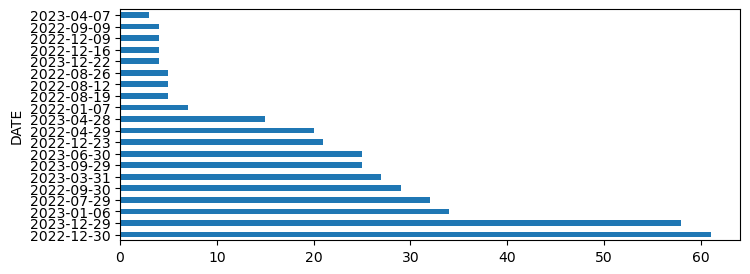

In [19]:
count_date = df_diff_na.DATE.value_counts()
a = count_date[:20]
a.index = a.index.strftime('%Y-%m-%d')
a.plot.barh(figsize = (8,3))

<Axes: ylabel='security_id'>

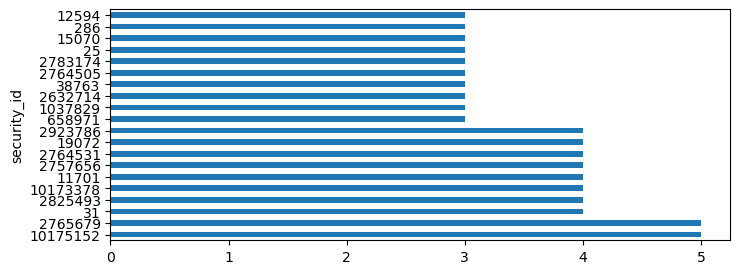

In [20]:
count_sec = df_diff_na[~df_diff_na.DATE.isin(eom)].security_id.value_counts()
a = count_sec[:20]
a.index = a.index.astype(str)
a.plot.barh(figsize = (8,3))

### Comparison resampled Sunday vs bloom

* Type A: 157 obs (differece >1%), l'erreur est très grande (certaines >50%)
* Type B: 389 (146 après enlever EOM) obs BBG a des valeurs, KC est NA
* Type C: 30 (16 après enlever EOM) obs BBG est NA, KC a des valeurs

Parmi 419 obs type A, B, 257 obs est end of month, c'est probablement du à l'initatlisation de ta table avec frequence 'WEEKLY_PLUS_EOM'
il reste 162 obs (146 type B, 16 type C)

|       |   2023-12-31|   2022-07-31|   2022-10-02|   2023-04-02|   2023-07-02|   2023-10-01|   2023-01-01|   2022-05-01|   2023-04-30 |
|:------|----------:|--------------:|------------:|----------:|------------:|---------------:|--------------:|-------------:|----------:|
| count |                    56 |                    33 |                    30 |                    28 |                    26 |                    25 |                    22 |                    21 |                    16 |

In [21]:
df_1gy_sun = pd.concat((df_1gy_excel_sun.stack(), df_1gy_res_sun.stack()), axis =1)
df_1gy_sun.columns = ['excel', 'resampled']
df_1gy_sun['diff'] = (df_1gy_sun.resampled - df_1gy_sun.excel)/df_1gy_sun.resampled
df_1gy_sun = detail_diff(df_1gy_sun, df_1gy_daily_ts)

2022-01-04 00:00:00


In [22]:
df_1gy_leg = df_1gy_daily_leg.stack(dropna = False)
idx = df_1gy_sun.reset_index().set_index(['prev. daily date','security_id']).index
idx = df_1gy_leg.index.intersection(idx)
df_1gy_sun = df_1gy_sun.reset_index().merge(df_1gy_leg.loc[idx].to_frame('legacy').reset_index(), how = 'left',
                                left_on =['prev. daily date', 'security_id'], right_on =['level_0', 'security_id'])

df_1gy_sun = df_1gy_sun.set_index(['DATE', 'security_id']).drop(columns = ['level_0'])

In [23]:
df_1gy_sun[df_1gy_sun['diff'].abs()>0.01].sort_values(by = ['DATE', 'security_id'])

BBG weekly  resample KC      diff  prev. value daily  \
DATE       security_id                                                         
2022-01-09 6254              0.085        0.055 -0.545455              0.055   
           47044             0.054        0.038 -0.421053              0.038   
2022-01-23 448              13.008       12.868 -0.010880             12.868   
           47044            -0.013       -0.015  0.133333             -0.015   
2022-01-30 3008458           1.264        1.279  0.011728              1.279   
...                            ...          ...       ...                ...   
2023-12-17 2764531           0.085        0.081 -0.049383              0.081   
           2765679          -0.159       -0.155 -0.025806             -0.155   
           3008458           0.880        0.855 -0.029240              0.855   
2023-12-24 448               8.417        8.300 -0.014096              8.300   
           15730            -0.295       -0.291 -0.013746             -0.291   

                       prev. daily date prev. weekday  nb days fill  \
DATE       security_id                                                
2022-01-09 6254              2022-01-09        Sunday           0.0   
           47044             2022-01-09        Sunday           0.0   
2022-01-23 448               2022-01-23        Sunday           0.0   
           47044             2022-01-23        Sunday           0.0   
2022-01-30 3008458           2022-01-30        Sunday           0.0   
...                                 ...           ...           ...   
2023-12-17 2764531           2023-12-16      Saturday           1.0   
           2765679           2023-12-12       Tuesday           5.0   
           3008458           2023-12-16      Saturday           1.0   
2023-12-24 448               2023-12-23      Saturday           1.0   
           15730             2023-12-19       Tuesday           5.0   

                        next value daily next daily date  legacy  
DATE       security_id                                            
2022-01-09 6254                    0.055      2022-01-09     NaN  
           47044                   0.038      2022-01-09     NaN  
2022-01-23 448                    12.868      2022-01-23     NaN  
           47044                  -0.015      2022-01-23     NaN  
2022-01-30 3008458                 1.279      2022-01-30     NaN  
...                                  ...             ...     ...  
2023-12-17 2764531                 0.081      2023-12-19     NaN  
           2765679                   NaN      2023-12-17  -0.155  
           3008458                 0.855      2023-12-27     NaN  
2023-12-24 448                       NaN      2023-12-24     NaN  
           15730                     NaN      2023-12-24  -0.291  

[157 rows x 10 columns]

In [24]:
df_diff_na  = df_1gy_sun[df_1gy_sun['diff'].isna() & (df_1gy_sun['resample KC']!=0)].sort_values(by = ['security_id', 'DATE'])
df_diff_na = df_diff_na.reset_index()
print('Number of NA:\n',df_diff_na.isna().sum()[['BBG weekly','resample KC']])

Number of NA:
 BBG weekly      30
resample KC    389
dtype: int64


In [25]:
count_sec = df_diff_na.security_id.value_counts()
count_date = df_diff_na.DATE.value_counts()

<Axes: ylabel='DATE'>

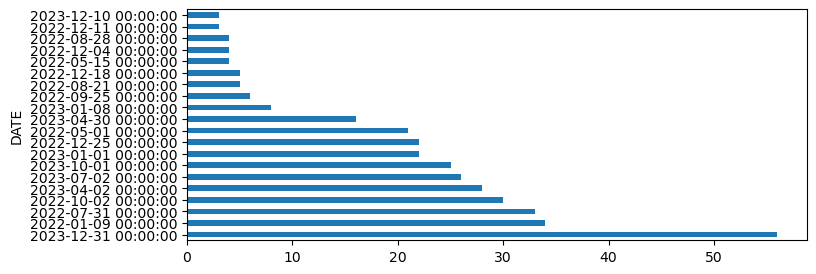

In [26]:
a = count_date[:20]
#a.index = a.index.strftime('%Y-%m-%d')
a.plot.barh(figsize = (8,3))

In [27]:
print('Number of NA before deleting EOM:\n', df_diff_na[['BBG weekly','resample KC']].isna().sum())
print('-------------')
print('Number of NA after deleting EOM:\n', df_diff_na[~df_diff_na.DATE.isin(eom+pd.Timedelta('2D'))][['BBG weekly','resample KC']].isna().sum())

Number of NA before deleting EOM:
 BBG weekly      30
resample KC    389
dtype: int64
-------------
Number of NA after deleting EOM:
 BBG weekly      16
resample KC    146
dtype: int64


In [28]:
243+14

257

# End of notebook

In [29]:
df_1gy_daily_ts[2765679].iloc[170:].dropna()

2022-06-28   -3.370
2022-08-23   -3.354
2022-09-02   -3.469
2022-09-11   -3.373
2022-09-12   -3.373
              ...  
2023-08-23   -0.180
2023-10-23   -0.170
2023-11-14   -0.130
2023-11-15   -0.154
2023-12-12   -0.155
Name: 2765679, Length: 24, dtype: float64

In [30]:
n = count_sec[count_sec==4].index
df_diff_na[df_diff_na.security_id.isin(n)]

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily  \
33  2022-01-09          436       0.829          NaN   NaN              0.829   
34  2022-10-02          436       1.080          NaN   NaN              1.080   
35  2023-12-17          436       1.098          NaN   NaN              1.098   
36  2023-12-31          436       1.098          NaN   NaN              1.098   
44  2022-07-31         6672      16.794          NaN   NaN             16.794   
..         ...          ...         ...          ...   ...                ...   
365 2023-12-31      2962159      -0.282          NaN   NaN             -0.282   
385 2022-05-01      3031213       0.486          NaN   NaN              0.486   
386 2023-01-08      3031213       0.477          NaN   NaN              0.477   
387 2023-10-01      3031213       0.963          NaN   NaN              0.963   
388 2023-12-31      3031213       1.225          NaN   NaN              1.225   

    prev. daily date prev. weekday  nb days fill  next value daily  \
33        2022-01-01      Saturday           8.0             0.826   
34        2022-09-12        Monday          20.0             1.080   
35        2023-12-10        Sunday           7.0             1.098   
36        2023-12-19       Tuesday          12.0               NaN   
44        2022-07-24        Sunday           7.0            16.794   
..               ...           ...           ...               ...   
365       2023-12-21      Thursday          10.0               NaN   
385       2022-04-22        Friday           9.0             0.469   
386       2023-01-01        Sunday           7.0             0.495   
387       2023-09-21      Thursday          10.0             1.053   
388       2023-12-15        Friday          16.0               NaN   

    next daily date  legacy  
33       2022-01-20     NaN  
34       2022-10-07   1.080  
35       2023-12-19     NaN  
36       2023-12-31   1.098  
44       2022-08-04     NaN  
..              ...     ...  
365      2023-12-31  -0.282  
385      2022-05-04   0.486  
386      2023-01-11     NaN  
387      2023-10-02   0.963  
388      2023-12-31   1.225  

[76 rows x 12 columns]

In [31]:
n = df_diff_na[df_diff_na.DATE=='20230106'].security_id.unique()
df_diff_na[df_diff_na.security_id.isin(n) & df_diff_na.DATE.isin(pd.to_datetime(['20221230', '20230106']))]

Empty DataFrame
Columns: [DATE, security_id, BBG weekly, resample KC, diff, prev. value daily, prev. daily date, prev. weekday, nb days fill, next value daily, next daily date, legacy]
Index: []

In [32]:
sec_common = df_1gy_daily_ts.columns
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')

In [33]:
sec_anom = [258,   11963,   15210,   15726,   17821,   18590,   18678,   38718,
         38763,   47044, 1037829, 2632714, 2752161, 2757656, 2764531, 2907194, 2925627]

In [34]:
df_1gy_daily_ts.columns[df_1gy_daily_ts.iloc[-1].notna()]

Index([11701, 13541, 19072, 392166, 2764505], dtype='int64', name='security_id')

In [35]:
ticker.loc[df_1gy_daily_ts.columns[df_1gy_daily_ts.iloc[0].notna()].difference(sec_anom)].T

security_id 25       31       89       210      286      359      436       \
fund_ticker    BB FP    EN FP   ERA FP   KER FP    VK FP   VID SM   UNI IM   
td_id              1        1        1        1        1       22        5   

security_id 448      6254     6607      ... 2921870   2923786  3008458   \
fund_ticker  CAST SS   LHA GR  MUV2 GR  ...  VRLA FP  CMCOM NA   ALE PW   
td_id             17        2        2  ...        1        38       40   

security_id 3010803  3018908  3031213   10172537 10175065  10175152 10175242  
fund_ticker   SOL SM   PCF PW   HUG PW  NORBB SS   KCO GR  ECMPA NA   LNZ AV  
td_id             22       40       40        17        2         5        7  

[2 rows x 69 columns]

In [36]:
df_1gy_daily_ts.columns[df_1gy_daily_ts.loc['20230101'].isna()].difference(sec_anom)

Index([34280, 76761, 295511, 363239, 673005], dtype='int64', name='security_id')

In [37]:
ticker.loc[[34280, 76761, 295511, 363239, 673005]].T

34280    76761    295511    363239  673005
fund_ticker  LECN SW  SOLV BB  SEA1 NO  ALGAU FP  SEV FP
td_id             18       26       72         1       1

#### stocks dont 1GY sont dispo le 1er janvier, début l'année fiscale, même si un weekend
Tous les stocks dont l'année fiscale commence en janvier ont des données 1GY

In [38]:
df_fy_23 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20221228', '20230105'))]
df_fy_23 = df_fy_23.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

df_fy_22 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20211228', '20220105'))]
df_fy_22 = df_fy_22.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

In [39]:
df_fy_23[df_fy_23['2023-01-01'].isna()]

Empty DataFrame
Columns: [2022-12-28 00:00:00, 2022-12-29 00:00:00, 2022-12-30 00:00:00, 2022-12-31 00:00:00, 2023-01-01 00:00:00, 2023-01-02 00:00:00, 2023-01-03 00:00:00, 2023-01-04 00:00:00, 2023-01-05 00:00:00]
Index: []

In [40]:
df_fy_22[df_fy_22['2022-01-01'].isna()]

Empty DataFrame
Columns: [2022-01-01 00:00:00, 2022-01-02 00:00:00, 2022-01-03 00:00:00, 2022-01-04 00:00:00, 2022-01-05 00:00:00]
Index: []

#### Si les données de 1GY début l'AF est remplies par 2GY de l'année précédente: NON

In [41]:
df = pd.concat((df_1gy_daily_ts.loc['2023-01-01'].to_frame('1GY_20230101'),
                df_2gy_daily_ts.loc['2022-01-01'].to_frame('2GY_20220101')), axis = 1)
df = df[~df.index.isin(sec_anom)]
df['is_filled'] = df['1GY_20230101'] == df['2GY_20220101']
df[df.is_filled]

Empty DataFrame
Columns: [1GY_20230101, 2GY_20220101, is_filled]
Index: []